In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

aml_folder_new = 'N:/lab_boztug/projects/pharmacoscopy_codebase/test_out_folders/aml/P1'
aml_folder_orig = 'N:/lab_boztug/projects/pharmacoscopy_codebase/test_out_folders/aml/P1'
aml_filename = '2016012-13_viabilities.csv'


nb_folder_new = 'N:/lab_boztug/projects/pharmacoscopy_codebase/test_out_folders/nb/SST062'
nb_folder_orig = 'N:/lab_boztug/projects/neuroblastoma_screening/postprocessing_aae_outputs_no_inter/SST062'
nb_filename = '2214046-47_viabilities.csv'

In [30]:
def make_dfs_match(longer_df, shorter_df):
    keep_vec = np.zeros(longer_df.shape[0], dtype=bool)
    unique_plates = longer_df['Plate'].unique()
    for plate in unique_plates:
        plate_mask = (longer_df['Plate'] == plate).to_numpy()
        plate_wells_shorter_df = shorter_df[shorter_df['Plate'] == plate]['Metadata_Well'].to_numpy()
        well_mask = longer_df['Metadata_Well'].isin(plate_wells_shorter_df).to_numpy()
        keep_vec = keep_vec | (plate_mask & well_mask)
    longer_df = longer_df[keep_vec]
    return longer_df

def load_dfs_and_compare(orig_folder, new_folder, df_filename, target_populations):
    df_orig = pd.read_csv(os.path.join(orig_folder, df_filename))
    df_new = pd.read_csv(os.path.join(new_folder, df_filename))
    orig_columns = list(df_orig.columns)
    new_columns = list(df_new.columns)
    diff_columns = list(set(orig_columns).symmetric_difference(set(new_columns)))
    if len(diff_columns) > 0:
        print('The following columns are not matching')
        print(diff_columns)
    df_orig = df_orig.sort_values(['Plate', 'Metadata_Well'])
    df_new = df_new.sort_values(['Plate', 'Metadata_Well'])
    if df_orig.shape[0] != df_new.shape[0]:
        print('The number of rows is not matching')
        print(df_orig.shape[0], df_new.shape[0])
        print('Matching dataframes to be able to continue')
        if df_orig.shape[0] > df_new.shape[0]:
            df_orig = make_dfs_match(df_orig, df_new)
        else:
            df_new = make_dfs_match(df_new, df_orig)
    matches_found = 0
    if isinstance(target_populations[0], str):
        target_columns = ['NumberOfCells'] + ['NumberOfCells_{}'.format(pop) for pop in target_populations]
    else:
        target_columns = [['NumberOfCells', 'NumberOfCells']] + [['NumberOfCells_{}'.format(pop1), 'NumberOfCells_{}'.format(pop2)] for pop1, pop2 in target_populations]
    for col in target_columns:
        if isinstance(col, str):
            col1 = col
            col2 = col
        else:
            col1, col2 = col
        vals_orig = df_orig[col1].to_numpy()
        vals_new = df_new[col2].to_numpy()
        if (vals_orig == vals_new).all():
            matches_found += 1
            print('Column {} matches'.format(col))
        else:
            print('Mismatch found for column {}'.format(col))
            print('This affects {} rows'.format(np.sum(vals_orig != vals_new)))
    if matches_found == len(target_columns):
        print('All cellnumbers match. All good.')
    else:
        print('Mismatches found. Plotting correlation to understand why')
        fig, ax = plt.subplots(figsize=(6*len(target_columns),6), ncols=len(target_columns))
        for i in range(len(target_columns)):
            col = target_columns[i]
            if isinstance(col, str):
                col1 = col
                col2 = col
            else:
                col1, col2 = col
            vals_orig = df_orig[col1].to_numpy()
            vals_new = df_new[col2].to_numpy()
            ax[i].scatter(vals_orig, vals_new)
            ax[i].set_xlabel('Orig')
            ax[i].set_ylabel('New')
            ax[i].set_title(col1)
        fig.show()
    return
    
load_dfs_and_compare(aml_folder_orig, aml_folder_new, aml_filename, ['CD3', 'CD117'])

Column NumberOfCells matches
Column NumberOfCells_CD3 matches
Column NumberOfCells_CD117 matches
All cellnumbers match. All good.


The following columns are not matching
['NumberOfCells_AAE_cluster_2.0', 'NumberOfCells_AAE_cluster_1.0', 'NumberOfCells_ADR', 'NumberOfCells_AAE_cluster_3.0', 'NumberOfCells_MES', 'NumberOfCells_DEAD']
The number of rows is not matching
1811 1889
Matching dataframes to be able to continue
Mismatch found for column ['NumberOfCells', 'NumberOfCells']
This affects 1811 rows
Mismatch found for column ['NumberOfCells_AAE_cluster_1.0', 'NumberOfCells_ADR']
This affects 1811 rows
Mismatch found for column ['NumberOfCells_AAE_cluster_2.0', 'NumberOfCells_MES']
This affects 1811 rows
Mismatches found. Plotting correlation to understand why


C:\Users\ben.haladik\AppData\Local\Temp\ipykernel_37312\790156793.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


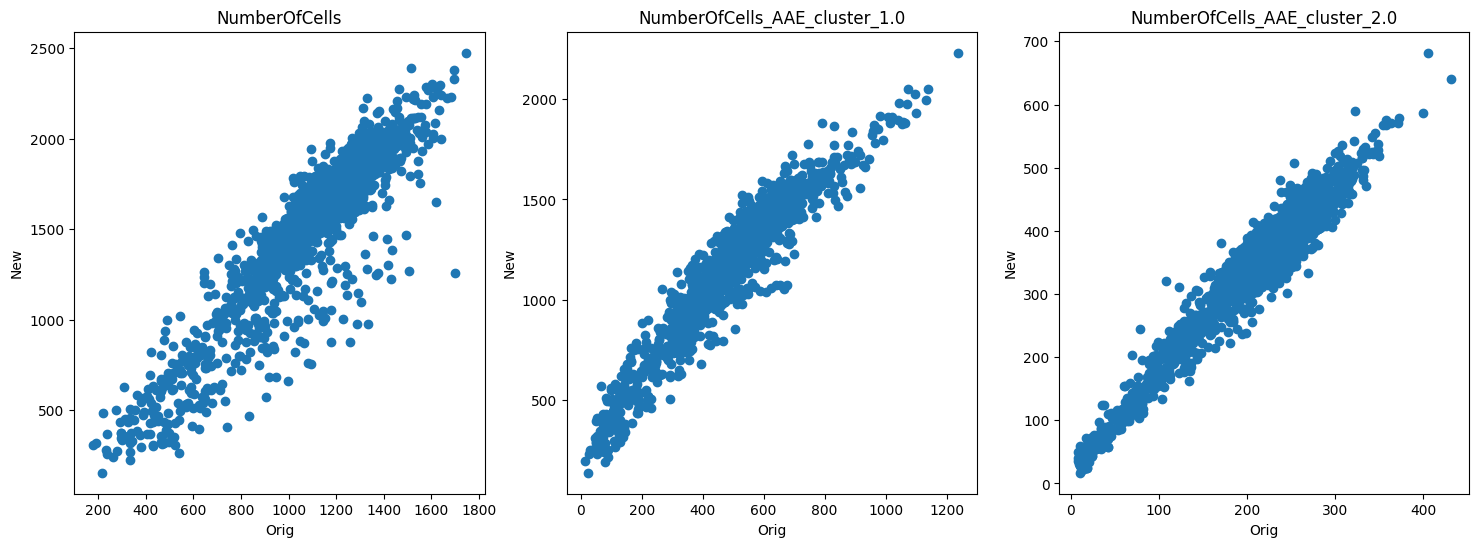

In [31]:
load_dfs_and_compare(nb_folder_orig, nb_folder_new, nb_filename, [['AAE_cluster_1.0', 'ADR'], ['AAE_cluster_2.0', 'MES']])